# LSTM model

ref: https://zhuanlan.zhihu.com/p/104475016

In [59]:
# -*- coding:UTF-8 -*-
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
# model
# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x



## input, 土壤蒸发量, 降水

       年份  月份  降水量(mm)  土壤蒸发量(mm)  10cm湿度(kg/m2)  40cm湿度(kg/m2)  \
0    2012   1     2.29       0.61          13.73          30.87   
1    2012   2     2.29       0.86          13.00          30.87   
2    2012   3    21.84       1.91          12.60          30.87   
3    2012   4     6.10       7.20          11.97          30.73   
4    2012   5    50.80      18.10          14.18          29.99   
..    ...  ..      ...        ...            ...            ...   
118  2021  11   530.86       1.44          13.91          52.17   
119  2021  12   193.80       0.93          13.14          52.14   
120  2022   1   607.31       0.44          12.45          52.14   
121  2022   2   796.04       0.27          12.10          52.14   
122  2022   3   115.57       5.98          14.96          52.13   

     100cm湿度(kg/m2)  200cm湿度(kg/m2)  
0             42.79          168.56  
1             42.79          168.56  
2             42.79          168.56  
3             42.76          168.56  
4    

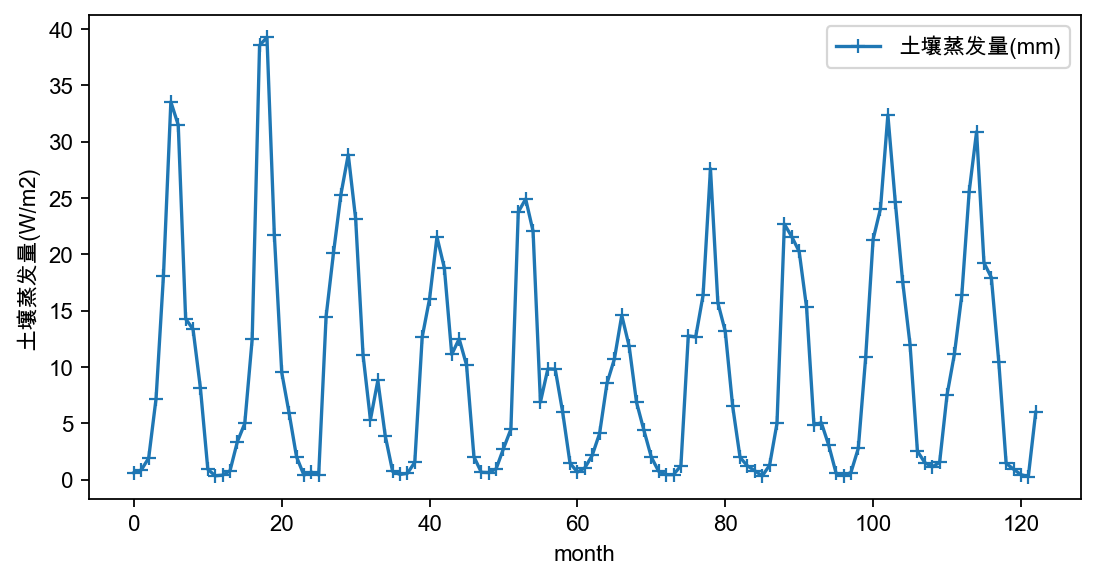

In [70]:
import pandas as pd
plt.rcParams['font.family'] = ['Arial Unicode MS']
#data4 = pd.read_excel(io=r'new土壤蒸发量2012—2022年.xlsx',sheet_name='sheet1-1')
data = pd.read_csv('./第2题_data_simplified.csv')
print(data)
#== 绘制土壤蒸发量
plt.figure(figsize=(8,4),dpi=160)
plt.plot(data['土壤蒸发量(mm)'],label='土壤蒸发量(mm)', linestyle='solid', marker='+')
plt.xlabel('month')
plt.ylabel('土壤蒸发量(W/m2)')
plt.legend()
plt.savefig('土壤蒸发量.pdf')


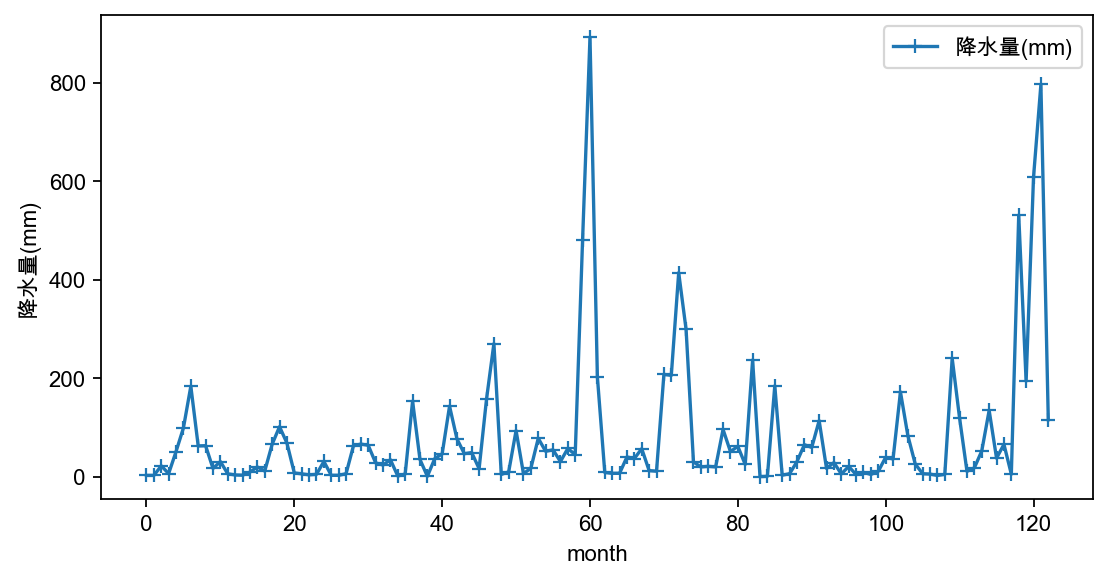

In [71]:
#== 绘制降水量
plt.figure(figsize=(8,4),dpi=160)
plt.plot(data['降水量(mm)'],label='降水量(mm)', linestyle='solid', marker='+')
plt.xlabel('month')
plt.ylabel('降水量(mm)')
plt.legend()
plt.savefig('降水量.pdf')


N = len(data['土壤蒸发量(mm)'])
x = np.column_stack((data['土壤蒸发量(mm)'],data['降水量(mm)']))
x = x.astype(np.float32)
x = torch.tensor(x) # 将np array 转成 tensor
#x = x.to(torch.float32) # 将数据类型转换成float32
#print(x)

## output, 土壤湿度

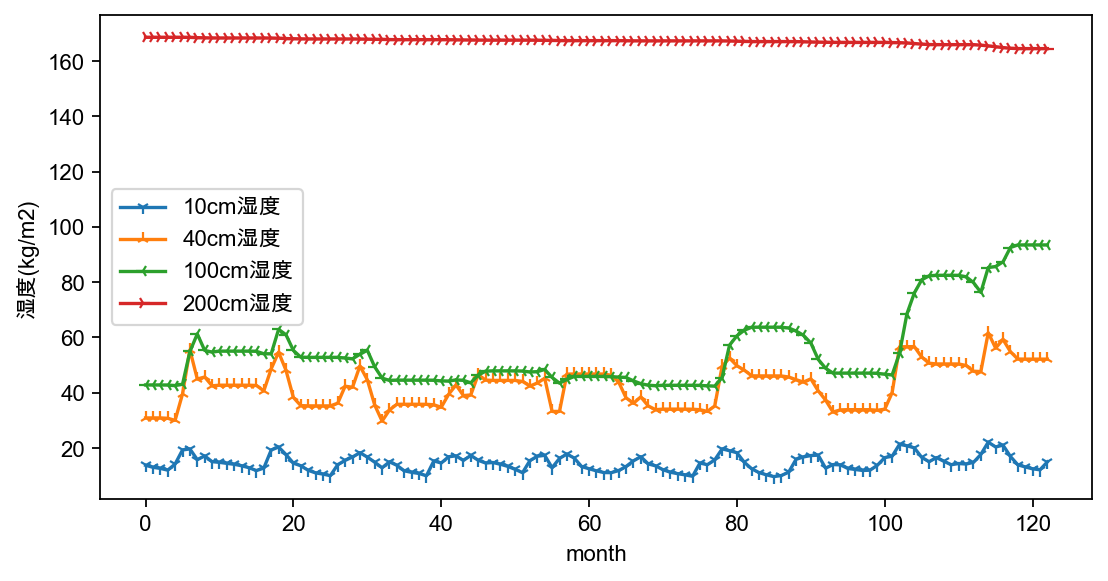

In [72]:
plt.figure(figsize=(8,4),dpi=160)
plt.plot(data['10cm湿度(kg/m2)'],label='10cm湿度', linestyle='solid', marker='1')
plt.plot(data['40cm湿度(kg/m2)'],label='40cm湿度', linestyle='solid', marker='2')
plt.plot(data['100cm湿度(kg/m2)'],label='100cm湿度', linestyle='solid', marker='3')
plt.plot(data['200cm湿度(kg/m2)'],label='200cm湿度', linestyle='solid', marker='4')

plt.xlabel('month')
plt.ylabel('湿度(kg/m2)')
plt.legend()
plt.savefig('湿度.pdf')

y = np.column_stack((data['10cm湿度(kg/m2)'], data['40cm湿度(kg/m2)'],data['100cm湿度(kg/m2)'],data['200cm湿度(kg/m2)']))
y = y.astype(np.float32)
y = torch.tensor(y) # 将np array 转成 tensor
#print(y)

##  choose dataset for training and testing

In [73]:
data_len = len(x)
print(data_len)
train_data_len = 120
train_x = x[:train_data_len]
train_y = y[:train_data_len]
# 输入特征 降水和蒸发 ， 输出为4个深度的含水量
INPUT_FEATURES_NUM = 2
OUTPUT_FEATURES_NUM = 4
# 时间，按月
t = np.linspace(1,data_len, data_len)
t_for_training = t[:train_data_len]

#== 测试样本
N = 120
test_x = x[train_data_len: N]
test_y = y[train_data_len: N]
t_for_testing = t[train_data_len: N]

123


In [64]:
# 中间层64个单元 2层深 绘制LSTM结构
lstm_model = LstmRNN(INPUT_FEATURES_NUM, 64, output_size=OUTPUT_FEATURES_NUM, num_layers=2) # 16 hidden units
print(lstm_model)

from torchviz import make_dot
x0 = torch.randn(1, 5, 2).requires_grad_(True)  # 定义一个网络的输入值
y0 = lstm_model(x0) # 获取网络的预测值

MyConvNetVis = make_dot(y0,params=dict(list(lstm_model.named_parameters())+[('降雨,蒸发', x0),('土壤湿度',y0)]))
MyConvNetVis.format = "pdf"
MyConvNetVis.view()# 生成文件

LstmRNN(
  (lstm): LSTM(2, 64, num_layers=2)
  (forwardCalculation): Linear(in_features=64, out_features=4, bias=True)
)


'Digraph.gv.pdf'

## training

In [90]:
import os
# ----------------- train -------------------
train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5
train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM) # set batch size to 5

print('LSTM model:', lstm_model)
print('model.parameters:', lstm_model.parameters)

#loss_function = nn.MSELoss()
loss_function = nn.HuberLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

max_epochs = 20000

if os.path.exists('model.pth'): # 在已有模型上继续训练
    lstm_model.load_state_dict(torch.load('model.pth')) 


for epoch in range(max_epochs):
    output = lstm_model(train_x_tensor)
    loss = loss_function(output, train_y_tensor)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch+1) % 100 == 0:
        print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))

torch.save(lstm_model.state_dict(),'model.pth') # 保存模型到 

LSTM model: LstmRNN(
  (lstm): LSTM(2, 64, num_layers=2)
  (forwardCalculation): Linear(in_features=64, out_features=4, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(2, 64, num_layers=2)
  (forwardCalculation): Linear(in_features=64, out_features=4, bias=True)
)>
Epoch [1/20000], Loss: 0.00007
The loss value is reached


## 检验预测效果

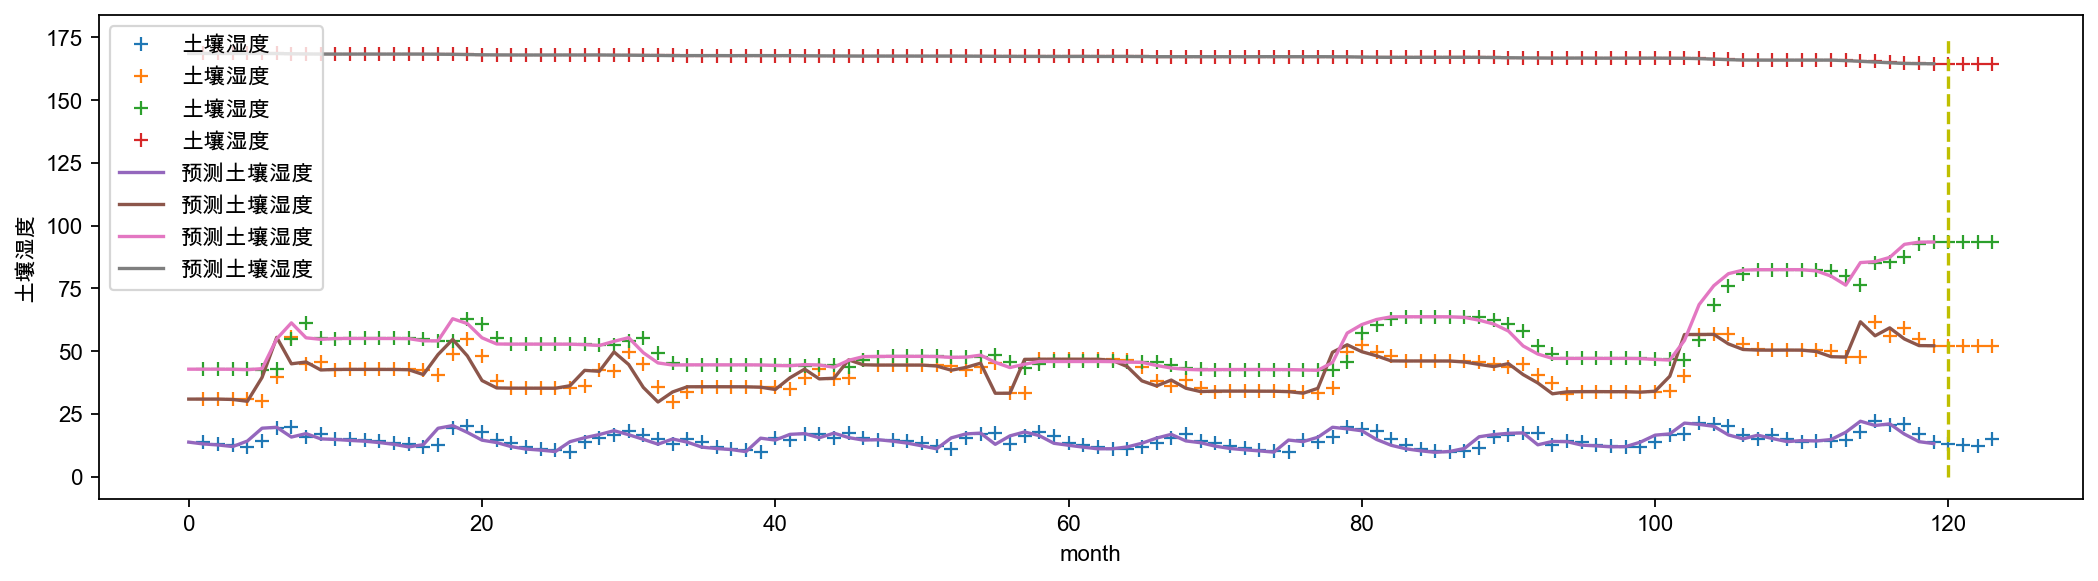

In [82]:
# prediction on training dataset
predictive_y_for_training = lstm_model(train_x_tensor)
predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
# ----------------- test -------------------
# lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
lstm_model = lstm_model.eval() # switch to testing model

# prediction on test dataset
x_tensor = x[:N].reshape(-1, 5,INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set

predictive_y = lstm_model(x_tensor)
predictive_y = predictive_y.view(-1, OUTPUT_FEATURES_NUM).data.numpy()


plt.figure(figsize=(16,4),dpi=160)
plt.plot(t,y,label='土壤湿度', linestyle='', marker='+')
plt.plot(predictive_y,label='预测土壤湿度') #pred
plt.vlines(120, 0, 175, 'y',linestyle='dashed')
plt.xlabel('month')
plt.ylabel('土壤湿度')
plt.legend()
 

## FFT 预测蒸发量

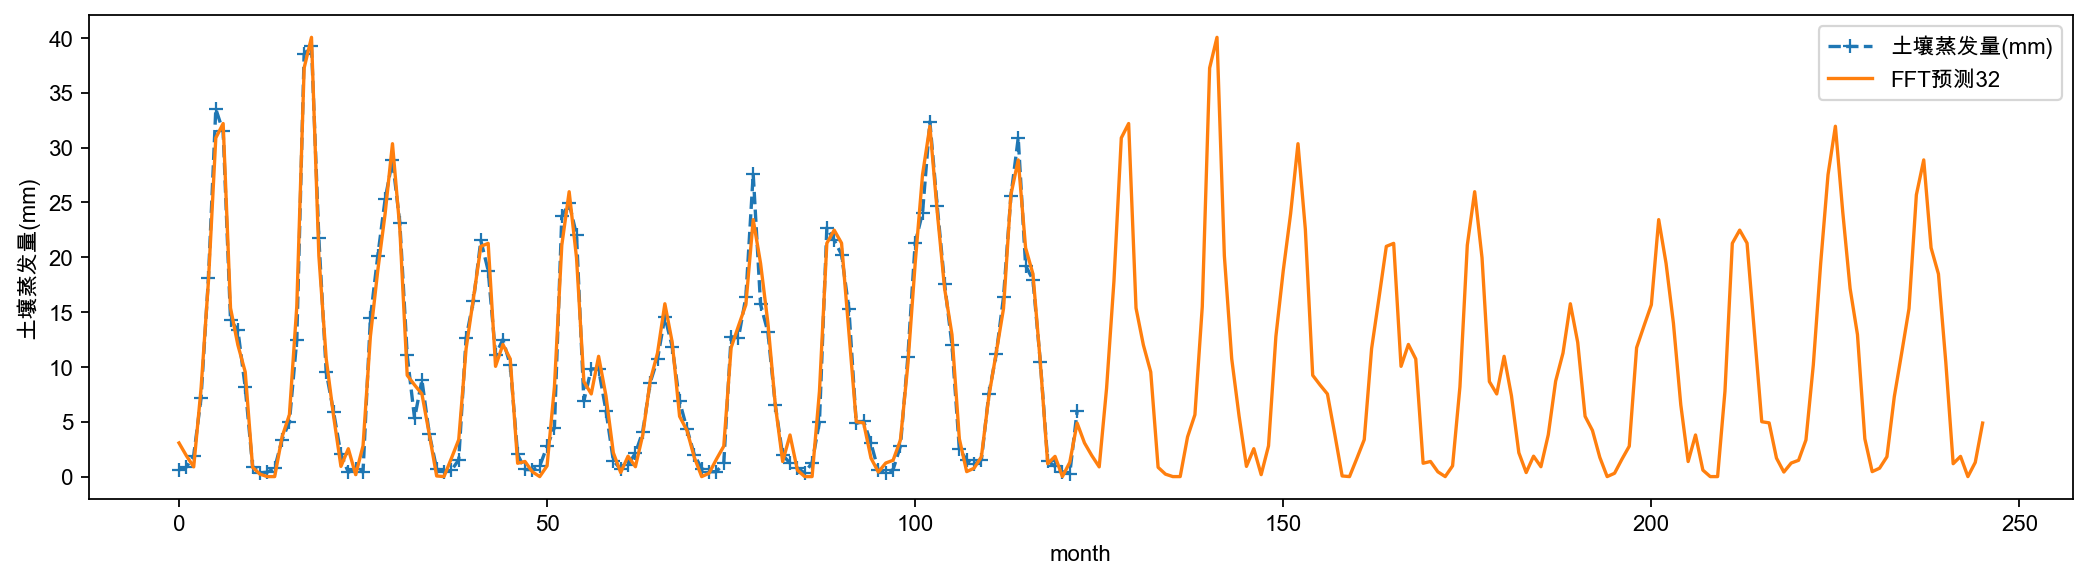

In [92]:
import math

fft_data = np.fft.fft(data['土壤蒸发量(mm)'])
fft_amp0 = np.array(np.abs(fft_data)/N*2)   # 用于计算双边谱

fn = 64
index = np.argpartition(fft_amp0.ravel(), -fn)[-fn:]
new_fft_data = []
for i in range(len(fft_data)):
    if i not in index:
        new_fft_data.append(0)
    else:
        new_fft_data.append(fft_data[i])

def fft_combine(bins, n, loops=1):
  length = int(len(bins) * loops)
  data = np.zeros(length)
  index = loops * np.arange(0, length, 1.0) / length * (2 * np.pi)
  for k, p in enumerate(bins[:n]):
    if k != 0 : p *= 2 # 除去直流成分之外, 其余的系数都 * 2
    data += np.real(p) * np.cos(k*index) # 余弦成分的系数为实数部分
    data -= np.imag(p) * np.sin(k*index) # 正弦成分的系数为负的虚数部分
  return index, data/len(bins)

index, pred_evapo = fft_combine(new_fft_data, int(len(new_fft_data)/2-1), 2) # 只关心一半数据
pred_evapo[pred_evapo < 0] = 0 #==负值设为0

plt.figure(figsize=(16,4),dpi=160)
plt.plot(data['土壤蒸发量(mm)'],label='土壤蒸发量(mm)', linestyle='dashed', marker='+')
plt.plot(pred_evapo,label='FFT预测'+str(int(fn/2)), linestyle='solid')
plt.xlabel('month')
plt.ylabel('土壤蒸发量(mm)')
plt.legend()
plt.savefig('蒸发量_预测.pdf')

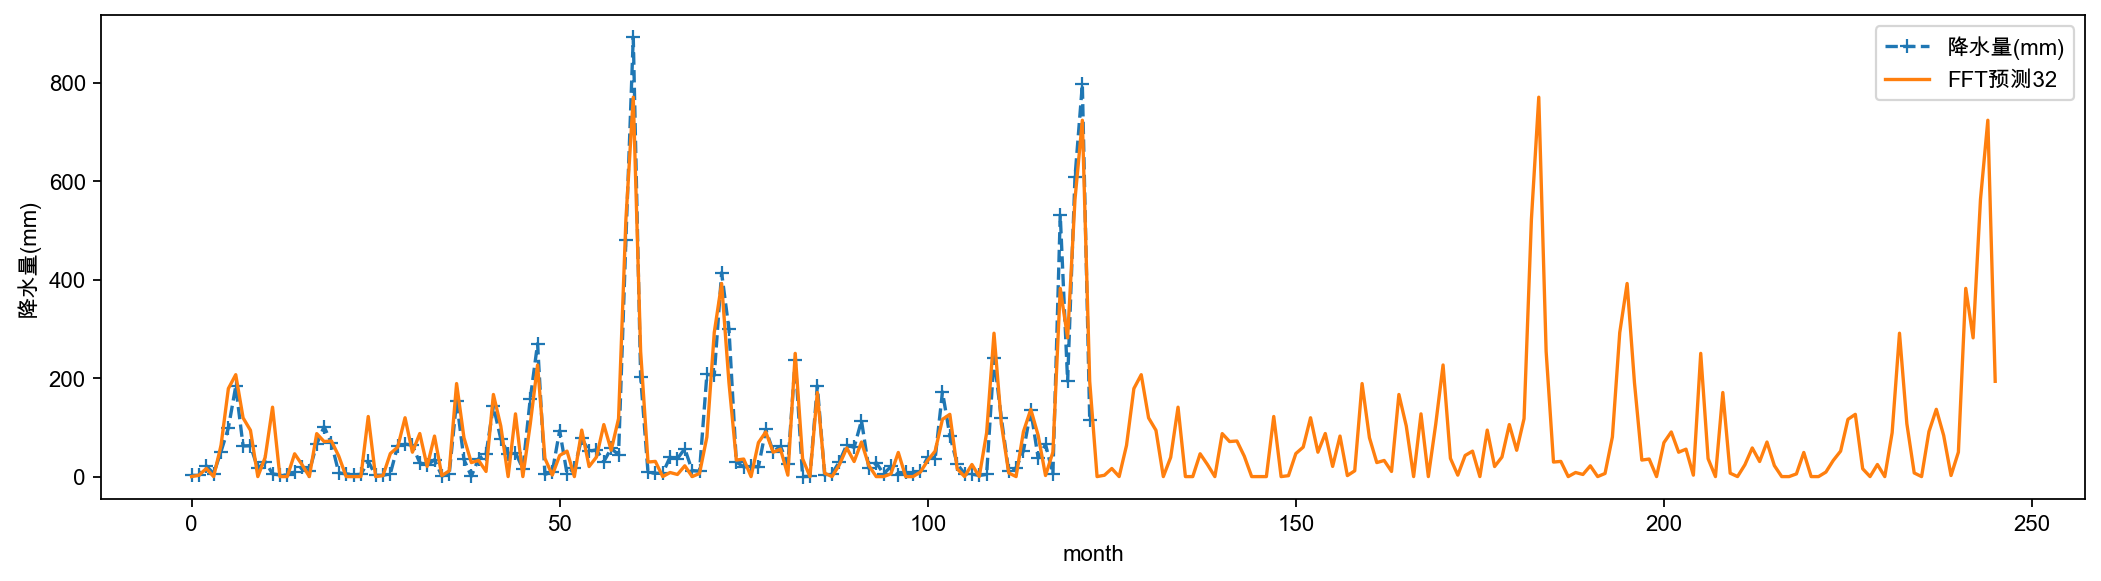

In [94]:
#============FFT预测降水
fft_data = np.fft.fft(data['降水量(mm)'])
fft_amp0 = np.array(np.abs(fft_data)/N*2) 

fn = 64
index = np.argpartition(fft_amp0.ravel(), -fn)[-fn:]
new_fft_data = []
for i in range(len(fft_data)):
    if i not in index:
        new_fft_data.append(0)
    else:
        new_fft_data.append(fft_data[i])

def fft_combine(bins, n, loops=1):
  length = int(len(bins) * loops)
  data = np.zeros(length)
  index = loops * np.arange(0, length, 1.0) / length * (2 * np.pi)
  for k, p in enumerate(bins[:n]):
    if k != 0 : p *= 2 # 除去直流成分之外, 其余的系数都 * 2
    data += np.real(p) * np.cos(k*index) # 余弦成分的系数为实数部分
    data -= np.imag(p) * np.sin(k*index) # 正弦成分的系数为负的虚数部分
  return index, data/len(bins)

index, pred_rain = fft_combine(new_fft_data, int(len(new_fft_data)/2-1), 2) # 只关心一半数据
pred_rain[pred_rain < 0] = 0 #==负值设为0

plt.figure(figsize=(16,4),dpi=160)
plt.plot(data['降水量(mm)'],label='降水量(mm)', linestyle='dashed', marker='+')
plt.plot(pred_rain,label='FFT预测'+str(int(fn/2)), linestyle='solid')
plt.xlabel('month')
plt.ylabel('降水量(mm)')
plt.legend()
plt.savefig('降水量_预测.pdf')


246 246
[[ 15.977095  48.75285   83.69417  165.25957 ]
 [ 15.899992  48.771164  83.37152  165.61728 ]
 [ 17.270546  49.649918  64.34265  168.93567 ]
 [ 15.067288  48.602146  80.154564 164.97855 ]
 [ 12.679405  50.625732  60.569836 163.51637 ]
 [ 12.510652  48.654682  58.06447  167.98146 ]
 [ 16.187716  52.893784  83.14581  166.85771 ]
 [ 23.225903  56.916725  76.595215 167.46762 ]
 [ 22.5266    55.26133   60.550007 167.6836  ]
 [ 21.854342  51.198593  54.465683 166.56827 ]
 [ 16.451523  47.683624  60.415733 167.6582  ]
 [ 17.769989  51.98219   72.76377  166.37315 ]
 [ 17.735758  53.7821    73.46233  164.50111 ]
 [ 17.018635  44.94483   52.898186 166.42198 ]
 [ 15.618415  49.134415  56.106895 166.60818 ]
 [  8.0079    37.529     57.176407 164.32275 ]
 [ 12.214541  37.965916  57.304543 165.25131 ]
 [ 16.28431   60.073067  74.14845  165.49573 ]
 [ 12.698233  40.313953  44.77387  167.35284 ]
 [ 15.389671  49.9673    79.53217  164.93503 ]
 [ 15.221834  48.046852  50.13182  166.28061 ]
 [ 14

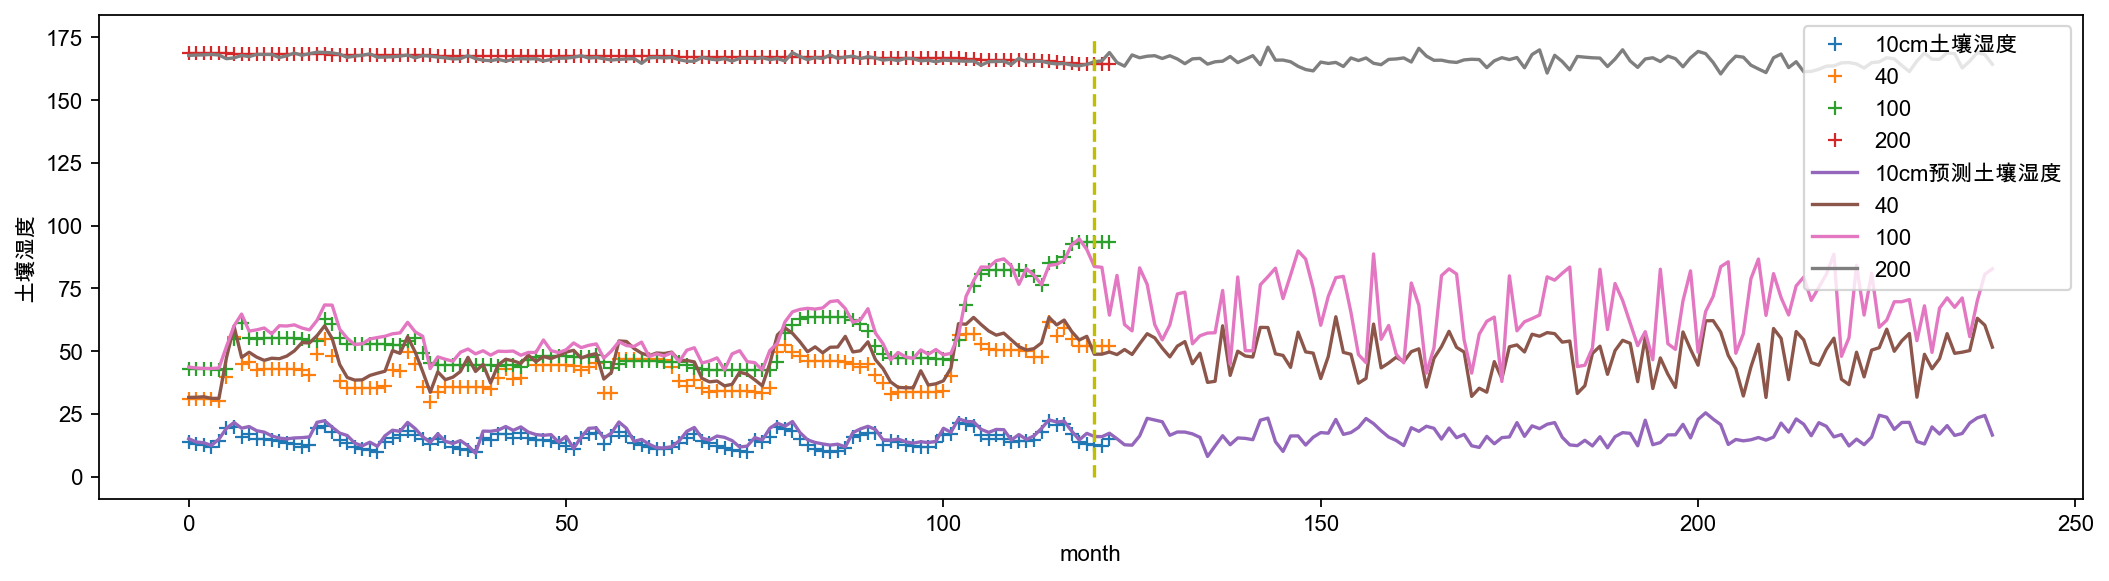

In [98]:

test_evapo = np.concatenate((data['土壤蒸发量(mm)'],pred_evapo[len(data['土壤蒸发量(mm)']):]), axis=-1)
#test_evapo = pred_evapo
test_rain = np.concatenate((data['降水量(mm)'],pred_rain[len(data['降水量(mm)']):len(test_evapo)]), axis=-1)
#test_rain = pred_rain
print(len(test_evapo),len(test_rain))
x_pred = np.column_stack((test_evapo,test_rain))
lstm_model = lstm_model.eval() # switch to testing model

# prediction on test dataset
x_pred = x_pred.astype(np.float32)
x_pred = torch.tensor(x_pred) # 将np array 转成 tensor
x_pred = x_pred[:240].reshape(-1, 5,INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set

predictive_y = lstm_model(x_pred)
predictive_y = predictive_y.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

plt.figure(figsize=(16,4),dpi=160)
plt.plot(y,label=['10cm土壤湿度','40','100','200'], linestyle='', marker='+')
plt.plot(predictive_y,label=['10cm预测土壤湿度','40','100','200']) #pred
plt.vlines(120, 0, 175, 'y',linestyle='dashed')

plt.xlabel('month')
plt.ylabel('土壤湿度')
plt.legend()
plt.savefig('土壤湿度_预测.pdf')

#预测近几个月
print(predictive_y[120:150])

1.8946521935056728


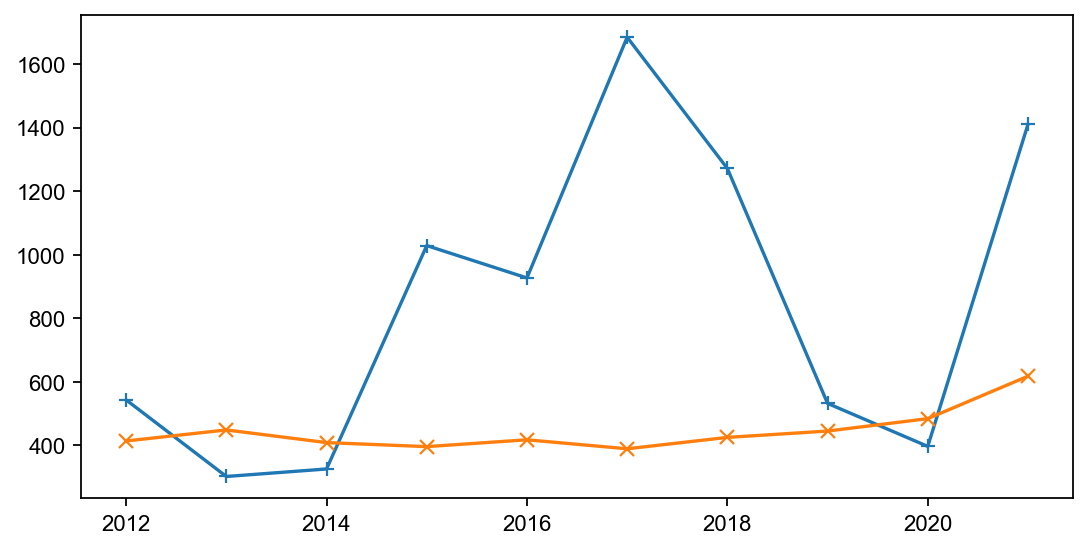

In [117]:
# 计算年降水量
t = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
ave_rain = []
for i  in range(len(t)):
    ave_rain.append(sum(data['降水量(mm)'][i*12:(i+1)*12]))

ave_wet = []
new_wet = (data['10cm湿度(kg/m2)'] + data['40cm湿度(kg/m2)'] + data['100cm湿度(kg/m2)'])/3
for i  in range(len(t)):
    ave_wet.append(sum(new_wet[i*12:(i+1)*12]))


plt.figure(figsize=(8,4),dpi=160)
#plt.yscale('log')
plt.plot(t,ave_rain,marker='+')
plt.plot(t,ave_wet,marker='x')

deta = sum(ave_rain)/sum(ave_wet)
print(deta)

